## Extended Kalman filter
-----

Implementing an EKF, which then estimates the trajectory of a vehicle using odometry, range and bearing measurements.
The vehicle is equipped with a simple type of LIDAR sensor, which returns range and bearing measurements corresponding to individual landmarks in the environment. The global positions of the landmarks are assumed to be known beforehand. We will also assume known data association, that is, which measurment belong to which landmark.


<table><tr>
<td> <img src="data/robot.png" alt="robot pose and lidar" width="680"/> </td>
<td> <img src="data/gtruth.png" alt="EKF short example 2" width="680"/> </td>
</tr></table>


### Motion Model

The vehicle motion model recieves linear and angular velocity odometry readings as inputs, and outputs the state (i.e., 2D pose) of the vehicle:

\begin{align}
\mathbf{x}_{k} &= \mathbf{x}_{k-1} + 
\begin{bmatrix}
\cos\theta_{k-1} &0 \\
\sin\theta_{k-1} &0 \\
0 &1
\end{bmatrix}
\left(
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ x \, y \, \theta \right]^T$ is the current 2D pose of the vehicle
- $v_k$ and $\omega_k$ are the linear and angular velocity odometry readings, which we use as inputs to the model

### Measurement Model

The measurement model relates the current pose of the vehicle to the LIDAR range and bearing measurements $\mathbf{y}^l_k = \left[r \, \phi \right]^T$.

\begin{align}
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

- $x_l$ and $y_l$ are the ground truth coordinates of the landmark $l$
- $x_k$ and $y_k$ and $\theta_{k}$ represent the current pose of the vehicle
- $d$ is the known distance between robot center and laser rangefinder (LIDAR)


## Getting Started
-----

We implement 2 steps:
- the prediction step uses odometry measurements and the motion model to produce a state and covariance estimate at a given timestep, and
- the correction step, which uses the range and bearing measurements provided by the LIDAR to correct the pose and pose covariance estimates

### Unpack the Data
First, let's unpack the available data:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv 

with open('data/data.pickle', 'rb') as f:
     data = pickle.load(f)

t = data['t']  # timestamps [s]
x_init  = data['x_init'] # initial x position [m]
y_init  = data['y_init'] # initial y position [m]
th_init = data['th_init'] # initial theta position [rad]

# input signal
v  = data['v']   # translational velocity input [m/s]
om = data['om']  # rotational velocity input [rad/s]

# bearing and range measurements, LIDAR constants
b = data['b']  # bearing to each landmarks center in the frame attached to the laser [rad]
r = data['r']  # range measurements [m]

l = data['l']  # x,y positions of landmarks [m]
d = data['d']  # distance between robot center and laser rangefinder [m]

### Initializing Parameters

Now that our data is loaded, we can begin getting things set up for our solver. One of the most important aspects of designing a filter is determining the input and measurement noise covariance matrices, as well as the initial state and covariance values.

In [2]:
v_var = data['v_var'] # translation velocity variance  
om_var = data['om_var']  # rotational velocity variance 
r_var = data['r_var']  # range measurements variance
b_var = data['b_var']  # bearing measurement variance

Q_km = np.diag([v_var, om_var]) # input noise covariance 
cov_y = np.diag([r_var, b_var])  # measurement noise covariance 

x_est = np.zeros([len(v), 3, 1])  # estimated states, x, y, and theta
P_est = np.zeros([len(v), 3, 3])  # state covariance matrices

x_est[0] = np.array([[x_init, y_init, th_init]]).T # initial state
P_est[0] = np.diag([1, 1, 0.1]) # initial state covariance

def wraptopi(x): # Wraps angle to (-pi,pi] range
    if x > np.pi:
        x = x - (np.floor(x / (2 * np.pi)) + 1) * 2 * np.pi
    elif x < -np.pi:
        x = x + (np.floor(x / (-2 * np.pi)) + 1) * 2 * np.pi
    return x


## Correction Step
-----

The measurement model relates the current pose of the vehicle to the LIDAR range and bearing measurements $\mathbf{y}^l_k = \left[r \, \phi \right]^T$.

\begin{align}
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

- $x_l$ and $y_l$ are the ground truth coordinates of the landmark $l$
- $x_k$ and $y_k$ and $\theta_{k}$ represent the current pose of the vehicle
- $d$ is the known distance between robot center and laser rangefinder (LIDAR)

Implement the measurement update function, which takes an available landmark measurement $l$ and updates the current state estimate $\check{x}_k$.

For each landmark measurement received at a given timestep $k$, you should implement the following steps:

- Compute the measurement model Jacobians at $\mathbf{\check{x}}_{k}$
\begin{align}
\mathbf{y}^l_k = &\mathbf{h}(\mathbf{x}_{k}, \mathbf{n}^l_k) \\\\
\mathbf{H}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0}& \, , \, \, \, \,
\mathbf{M}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{n}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0} \, .
\end{align}
- Compute the Kalman Gain
\begin{align}
\mathbf{K}_k &= \mathbf{\check{P}}_k \mathbf{H}_k^T \left(\mathbf{H}_k \mathbf{\check{P}}_k \mathbf{H}_k^T + \mathbf{M}_k \mathbf{R}_k \mathbf{M}_k^T \right)^{-1} 
\end{align}
- Correct the predicted state
\begin{align}
\mathbf{\check{y}}^l_k &= \mathbf{h}\left(\mathbf{\check{x}}_k, \mathbf{0}\right) \\
\mathbf{\hat{x}}_k &= \mathbf{\check{x}}_k + \mathbf{K}_k \left(\mathbf{y}^l_k - \mathbf{\check{y}}^l_k\right)
\end{align}
- Correct the covariance
\begin{align}
\mathbf{\hat{P}}_k &= \left(\mathbf{I} - \mathbf{K}_k \mathbf{H}_k \right)\mathbf{\check{P}}_k
\end{align}

In [ ]:
# Define non-linear measurement function h 
def h(Xk, lk, d):
    x_k = Xk[0, 0]
    y_k = Xk[1, 0]
    theta_k = Xk[2, 0]

    x_l = lk[0]
    y_l = lk[1]

    h1 = np.sqrt( (x_l - x_k - d*np.cos(theta_k))**2 +  (y_l - y_k - d*np.sin(theta_k))**2)
    h2 = np.arctan2(y_l - y_k - d*np.sin(theta_k), x_l - x_k - d*np.cos(theta_k))
    
    h_val = np.array([[h1, h2]]).T
    return h_val

# Define jacobian matrix H
def jacobH(Xk, lk, d):
    H = np.zeros([2, 3])
    x1 = Xk[0, 0]
    x2 = Xk[1, 0]
    x3 = Xk[2, 0]
    
    A = lk[0] - x1 - d * np.cos(x3)
    B = lk[1] - x2 - d * np.sin(x3)
    h1 = np.sqrt(A**2 + B**2)

    # partial h1, partial x    
    # print("-A", -A, "h1", h1)
    H[0, 0] = -A / h1

    # partial h1, partial y
    H[0, 1] = -B / h1

    # partial h1, partial theta
    H[0, 2] = (d * A * np.sin(x3) - d * B * np.cos(x3)) / h1

    # partial h2, partial x
    H[1, 0] = B / (A**2 + B**2)
    
    # partial h2, partial y
    H[1, 1] = -1 / (A**2 + B**2)

    # partial h2, partial theta
    H[1, 2] = (A / (A**2 + B**2)) * ( -d * np.cos(x3) - (B * d * np.sin(x3) )/A) -1

    return H

# for i in range(len(r[k])):
#     x_check, P_check = measurement_update(l[i], r[k, i], b[k, i], P_check, x_check)
def measurement_update(lk, rk, bk, P_check, x_check):
    
    # 1. Compute measurement Jacobian
    H = jacobH(x_check, lk, d[0])
    M  = np.identity(2)

    # 2. Compute Kalman Gain
    K = np.dot(P_check, H.T).dot( inv(H.dot(P_check).dot(H.T)  + M.dot(cov_y).dot(M.T)) )

    # 3. Correct predicted state (remember to wrap the angles to [-pi,pi])
    y_check =  h(x_check, lk, d[0])
    
    yk =  np.array([[rk, bk]]).T 
    x_hat = x_check + K.dot(yk-y_check)
    
    # 4. Correct covariance
    P_hat = ( np.identity(3) - K.dot(H) ).dot(P_check) 
    return x_hat, P_hat

## Prediction Step
-----
Now, implement the main filter loop, defining the prediction step of the EKF using the motion model provided:

\begin{align}
\mathbf{x}_{k} &= \mathbf{x}_{k-1} + T
\begin{bmatrix}
\cos\theta_{k-1} &0 \\
\sin\theta_{k-1} &0 \\
0 &1
\end{bmatrix}
\left(
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ x \, y \, \theta \right]^T$ is the current 2D pose of the vehicle
- $v_k$ and $\omega_k$ are the linear and angular velocity odometry readings, which we use as inputs to the model


\begin{align}
\mathbf{\check{x}}_k &= \mathbf{f}\left(\mathbf{\hat{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0} \right) \\
\mathbf{\check{P}}_k &= \mathbf{F}_{k-1}\mathbf{\hat{P}}_{k-1}\mathbf{F}_{k-1}^T + \mathbf{L}_{k-1}\mathbf{Q}_{k-1}\mathbf{L}_{k-1}^T \, .
\end{align}

Where

\begin{align}
\mathbf{F}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0}  \, , \, \, \, \,
\mathbf{L}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{w}_{k}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0} \, .
\end{align}

In [4]:
def f(x, v, omega):
    theta = x[2, 0]
    T = np.zeros([3, 2])
    T[0, 0] = np.cos(theta)
    T[1, 0] = np.sin(theta)
    T[2, 1] = 1
    u = np.zeros([2, 1])
    u[0, 0] = v
    u[1, 0] = omega

    xcheck = x + T.dot(u)
    return xcheck

def jacobF(xhat, v):
    F = np.identity(3)
    theta = xhat[2, 0]
    F[0, 2] = -v*np.sin(theta) 
    F[1, 2] = v*np.cos(theta)
    return F

def jacobL(xhat):
    L = np.zeros([3, 2])
    theta = xhat[2, 0]
    L[0, 0] = np.cos(theta)
    L[1, 0] = np.sin(theta)
    L[2, 1] = 1.0
    return L

#### 5. Main Filter Loop #######################################################################
for k in range(1, len(t)):  # start at 1 because we've set the initial prediciton

    delta_t = t[k] - t[k - 1]  # time step (difference between timestamps)

    # 1. Update state with odometry readings (remember to wrap the angles to [-pi,pi])
    x_check = f(x_est[k-1], v[k], om[k])
    
    # 2. Motion model jacobian with respect to last state
    F_km = jacobF(x_est[k-1], v[k])
    P_hat = P_est[k-1, :, :]

    # 3. Motion model jacobian with respect to noise
    L_km = jacobL(x_est[k-1])

    # 4. Propagate uncertainty
    P_check = F_km.dot(P_hat).dot(F_km.T) + L_km.dot(Q_km).dot(L_km.T)

    # 5. Update state estimate using available landmark measurements
    for i in range(len(r[k])):
        x_check, P_check = measurement_update(l[i], r[k, i], b[k, i], P_check, x_check)

    # Set final state predictions for timestep
    x_est[k, 0] = x_check[0]
    x_est[k, 1] = x_check[1]
    x_est[k, 2] = x_check[2]
    P_est[k, :, :] = P_check

Let's plot the resulting state estimates:

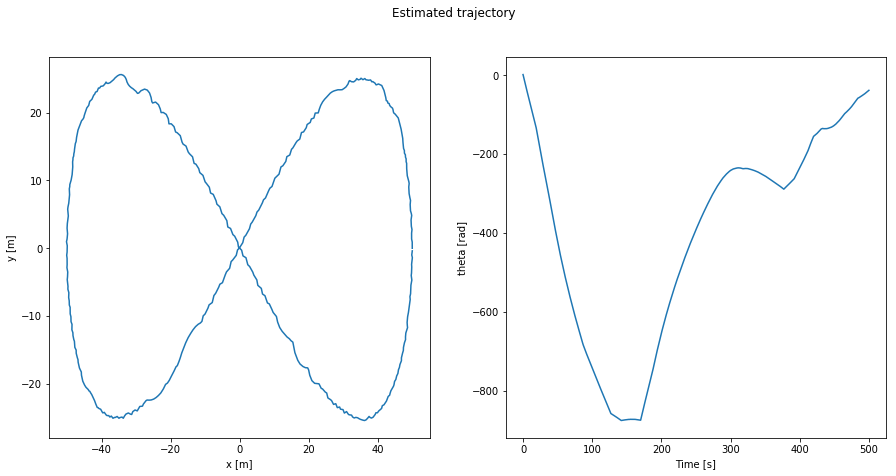

In [20]:
f, axs = plt.subplots(1, 2)
f.set_figheight(7)
f.set_figwidth(15)

f.suptitle('Estimated trajectory')
axs[0].plot(x_est[:, 0], x_est[:, 1])
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')

axs[1].plot(t[:], x_est[:, 2])
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('theta [rad]')
plt.show()

<table><tr>
<td> <img src="data/gtruth.png" alt="Ground Truth" width="450"/> </td>
<td> <img src="data/gtruth2.png" alt="Ground Truth" width="450"/> </td>
</tr></table>

Are you satisfied wth your results? The resulting trajectory should closely resemble the ground truth, with minor "jumps" in the orientation estimate due to angle wrapping. If this is the case, run the code below to produce your solution file.

In [6]:
with open('submission.pkl', 'wb') as f:
    pickle.dump(x_est, f, pickle.HIGHEST_PROTOCOL)